Splitting data into training and validation sets using panda dataframe:

In [2]:
import os
import numpy as np
import shutil
import pandas as pd

In [3]:
def train_validation_split():

    root_dir = "chest_xray/training"
    classes_dir = ["NORMAL","PNEUMONIA"]
    processed_dir = 'chest_xray/train'

    
    val_ratio = 0.10

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print(" Class Name " + cls + ": ")
        # Folder to copy images from
        src = processed_dir +"//" + cls  

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames) * (1 - (val_ratio)))])

        train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '//' + name for name in val_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+ str(len(val_FileNames)))

        os.makedirs(root_dir + '/train//' + cls)
        os.makedirs(root_dir + '/validation//' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train//' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + '/validation//' + cls)

train_validation_split()

 Class Name NORMAL: 
Total images: 1214
Training: 1092
Validation: 122


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'chest_xray/training/train//NORMAL'

Importing Libraries:

In [5]:
from keras.models import Model
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import SGD
import os
import cv2
import numpy as np
from keras import Sequential
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import callbacks
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import glob
import matplotlib.pyplot as plt
from keras.applications import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


In [3]:
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

GradCam visualization functions to demonstrate in the form of heat map where in the image the CNN is looking at while making prediction:

In [6]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Loading data:

In [11]:
IMG_SIZE = 150 # 224 -> 150
BATCH = 8
SEED = 42

In [7]:
main_path = "chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"validation")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

# val input addition
val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [8]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

#val finput addition
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

In [9]:
train_df = df_train
val_df = df_val

In [12]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             color_mode="grayscale",
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,                                           
                                             x_col = 'image',
                                            y_col = 'class',
                                         color_mode="grayscale",
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                          color_mode="grayscale",
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)


Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Function to create Confusion Matrix with confidence percentage:

In [13]:
def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')

# ResNet using Transfer Learning

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (IMG_SIZE, IMG_SIZE ,3), include_top = False)

In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 30,118,657
Trainable params: 6,553,857
Non-trainable params: 23,564,800
_________________________________________________________________


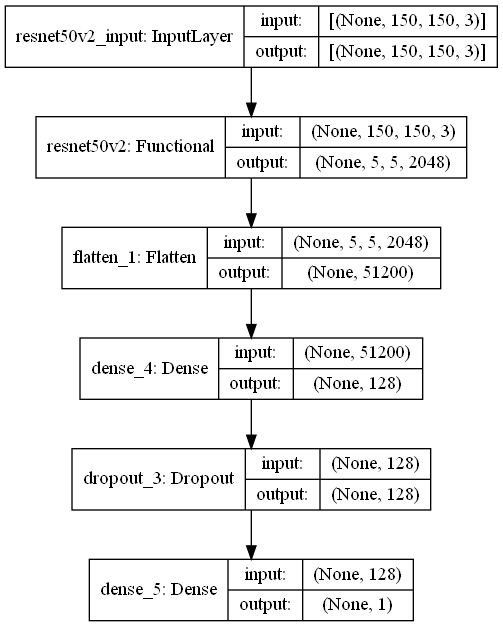

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)
 

In [ ]:
# hist = model.fit(ds_train,validation_data=ds_val,epochs=5)
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='RESNET50.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

hist = model.fit(
        ds_train,validation_data=ds_val,epochs=5,
        callbacks = callbacks_list)

Epoch 1/5
589/589 [==============================] - 333s 565ms/step - loss: 0.2434 - accuracy: 0.9155 - val_loss: 0.1328 - val_accuracy: 0.9446

Epoch 00001: val_loss improved from inf to 0.13280, saving model to RESNET50.h5
Epoch 2/5
589/589 [==============================] - 327s 556ms/step - loss: 0.1879 - accuracy: 0.9348 - val_loss: 0.1729 - val_accuracy: 0.9235

Epoch 00002: val_loss did not improve from 0.13280
Epoch 3/5
589/589 [==============================] - 330s 559ms/step - loss: 0.1668 - accuracy: 0.9422 - val_loss: 0.1133 - val_accuracy: 0.9579

Epoch 00003: val_loss improved from 0.13280 to 0.11333, saving model to RESNET50.h5
Epoch 4/5
589/589 [==============================] - 357s 606ms/step - loss: 0.1656 - accuracy: 0.9378 - val_loss: 0.1222 - val_accuracy: 0.9560

Epoch 00004: val_loss did not improve from 0.11333
Epoch 5/5
589/589 [==============================] - 335s 569ms/step - loss: 0.1657 - accuracy: 0.9422 - val_loss: 0.1926 - val_accuracy: 0.9273

Epoc

In [75]:
from tensorflow.keras.models import load_model
# Load the best saved model
resnet_model = load_model('RESNET50.h5')

In [ ]:
np.save('ResNet50_history.npy',hist.history)

In [76]:
history_dict=np.load('RESNET50_history.npy',allow_pickle='TRUE').item()

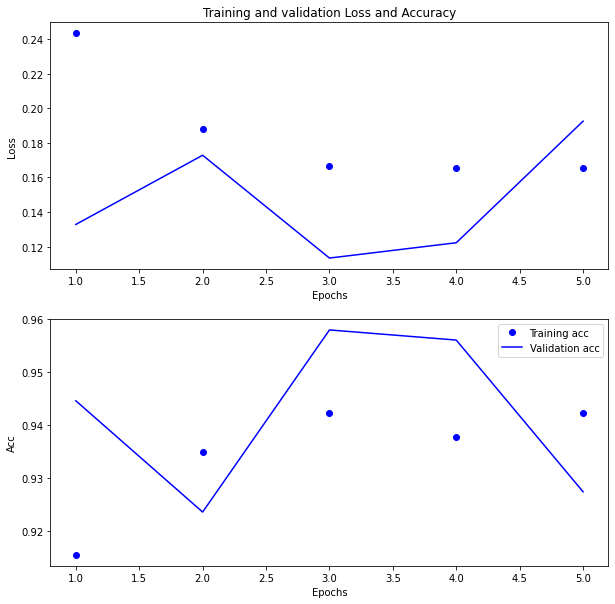

In [77]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [29]:
im_shape = (150,150)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255

test_generator = test_generator.flow_from_directory(test_path, target_size=(im_shape[0],im_shape[1]), shuffle=False,
                                                     class_mode='categorical', batch_size=BATCH, subset="training")#, color_mode='grayscale')
nb_test_samples = test_generator.samples

Found 624 images belonging to 2 classes.


In [51]:
resnet_model.evaluate(ds_test)

624/624 [==============================] - 69s 85ms/step - loss: 0.7004 - accuracy: 0.8285


[0.7004325985908508, 0.8285256624221802]

In [34]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = resnet_model.predict(test_generator, nb_test_samples // BATCH+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))


Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
      Pneumo       1.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.69      0.50      0.27       624
weighted avg       0.77      0.38      0.20       624



Accuracy for each class is given below.
Normal      : 100.0 %
Pneumo      : 0.0 %


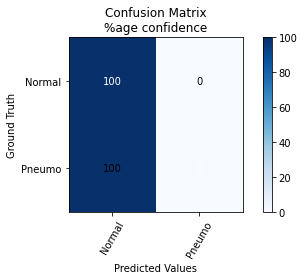

In [36]:
from sklearn import metrics
labels = ['Normal', 'Pneumo']
cm = metrics.confusion_matrix(test_generator.classes, y_pred)
plot_cm(cm, labels,'Confusion Matrix')

Few correctly and incorrectly classified images:

Original Class: 0 - Normal


<ipython-input-78-51f3a75a0242>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x=="0":


Predicted Class: 1 - Pneumonia


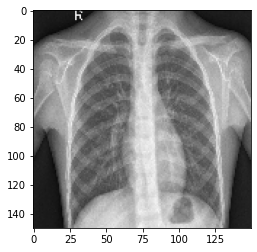

In [78]:
from keras.preprocessing import image
img = image.load_img("1.jpeg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 0 - Normal")
output = resnet_model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

Original Class: 1 - Pneumonia
Predicted Class: 1 - Pneumonia


<ipython-input-80-aaae0f8e1f69>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x=="0":


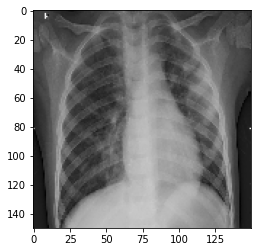

In [80]:
from keras.preprocessing import image
img = image.load_img("person3_virus_15.jpeg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 1 - Pneumonia")
output = resnet_model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

GradCam Results

In [89]:
last_conv_layer_name = "conv5_block3_1_conv"

# The local path to our target image
img_path = '2.jpeg'



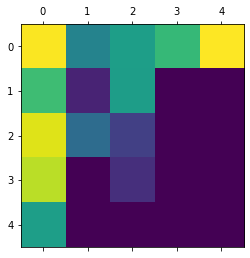

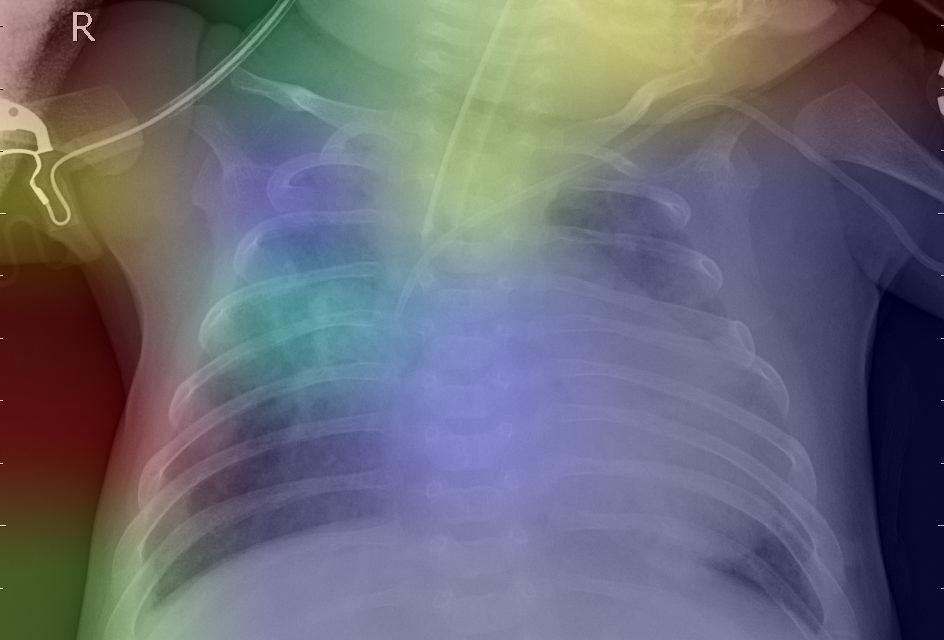

In [88]:
# Prepare image
img_size = (150,150)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

# Remove last layer's softmax
resnet_model.layers[-1].activation = None

# Print what the top predicted class is
preds = resnet_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, resnet_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

# MobileNet using Transfer Learning


In [14]:
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [15]:

# Loading MobileNet without top layer
im_shape = (224,224)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(im_shape[0], im_shape[1], 3))
seed = random.randint(1, 1000)

BATCH_SIZE = 32
num_classes = 2

learning_rate = 0.0001
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed))(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing MobileNet layers
for layer in base_model.layers:
    layer.trainable=False

optimizer = Adam(lr=learning_rate)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
TRAINING_DIR = 'chest_xray/train'
VAL_DIR = 'chest_xray/validation'
TEST_DIR = 'chest_xray/test'

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale=1./255,

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_generator.flow_from_directory(VAL_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)#, color_mode='grayscale')
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

Found 4709 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [18]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

C:\Users\Noor\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([1.93945634, 0.67367668])

In [19]:
from keras.preprocessing.image import ImageDataGenerator

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255

test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')
nb_test_samples = test_generator.samples

Found 624 images belonging to 2 classes.


Training the Data:

In [ ]:
epochs = 5

#Save the best model acoording to validation loss
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='MobileNet.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history_MobileNet = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/5
147/147 [==============================] - 236s 2s/step - loss: 0.3336 - accuracy: 0.8682 - val_loss: 0.1185 - val_accuracy: 0.9531

Epoch 00001: val_loss improved from inf to 0.11847, saving model to MobileNet.h5
Epoch 2/5
147/147 [==============================] - 214s 1s/step - loss: 0.1315 - accuracy: 0.9558 - val_loss: 0.1018 - val_accuracy: 0.9629

Epoch 00002: val_loss improved from 0.11847 to 0.10183, saving model to MobileNet.h5
Epoch 3/5
147/147 [==============================] - 213s 1s/step - loss: 0.1256 - accuracy: 0.9558 - val_loss: 0.0856 - val_accuracy: 0.9727

Epoch 00003: val_loss improved from 0.10183 to 0.08559, saving model to MobileNet.h5
Epoch 4/5
147/147 [==============================] - 212s 1s/step - loss: 0.0912 - accuracy: 0.9680 - val_loss: 0.0889 - val_accuracy: 0.9727

Epoch 00004: val_loss did not improve from 0.08559
Epoch 5/5
147/147 [==============================] - 213s 1s/step - loss: 0.0839 - accuracy: 0.9684 - val_loss: 0.0878 - val_a

In [ ]:
np.save('MobileNet_history.npy',history_MobileNet.history)


In [21]:
from tensorflow.keras.models import load_model
mobineNet_model = load_model('MobileNet.h5')

Original Class: 0 - Normal


<ipython-input-99-e683e9f48325>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x=="0":


Predicted Class: 1 - Pneumonia


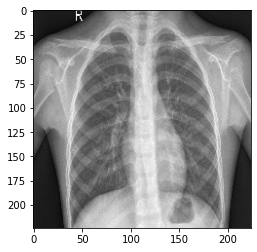

In [99]:
from keras.preprocessing import image
img = image.load_img("1.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 0 - Normal")
output = mobineNet_model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

In [ ]:
history_Mobilnet=np.load('RESNET50_history.npy',allow_pickle='TRUE').item()

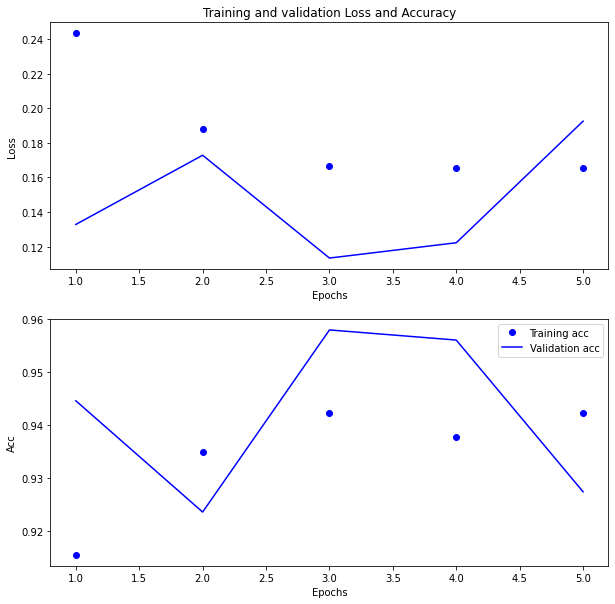

In [ ]:
import matplotlib.pyplot as plt

history_dict = history_Mobilnet
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [26]:
from tensorflow.keras.models import load_model
# Load the best saved model
MobileNet_model = load_model('MobileNet.h5')
MobileNet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

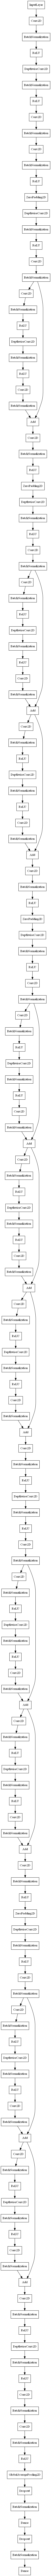

In [25]:
tf.keras.utils.plot_model(
    MobileNet_model, to_file='MobileNet_model.png', show_layer_names=False, show_shapes=False)

In [49]:
MobileNet_model.evaluate(test_generator)

78/78 [==============================] - 17s 200ms/step - loss: 1.4579 - accuracy: 0.7933


[1.4579083919525146, 0.7932692170143127]

In [27]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = MobileNet_model.predict(test_generator, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumo']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[118 116]
 [  2 388]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.50      0.67       234
      Pneumo       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



In [ ]:
def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')

Accuracy for each class is given below.
Normal      : 50.43 %
Pneumo      : 99.49 %


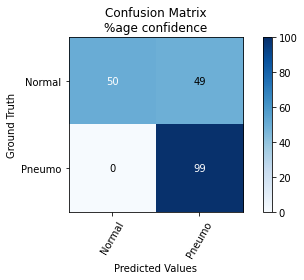

In [ ]:
from sklearn import metrics
labels = ['Normal', 'Pneumo']
cm = metrics.confusion_matrix(test_generator.classes, y_pred)
plot_cm(cm, labels,'Confusion Matrix')

Correctly And Incorrectly Classified Images:


Original Class: 0 - Normal
Predicted Class: 1 - Pneumonia


<ipython-input-29-3f6df6ef5c6a>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x=="0":


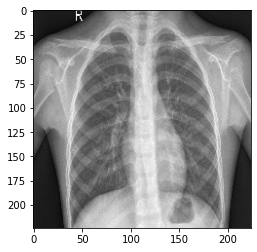

In [29]:
from keras.preprocessing import image
img = image.load_img("1.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 0 - Normal")
output = MobileNet_model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

Original Class: 1 - Pneumonia
Predicted Class: 1 - Pneumonia


<ipython-input-31-92cf4ed02f34>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x=="0":


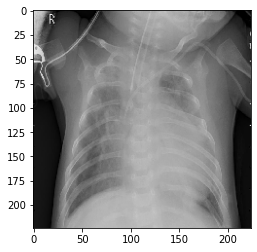

In [31]:
from keras.preprocessing import image
img = image.load_img("2.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 1 - Pneumonia")
output = MobileNet_model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

GradCam Results:


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [33]:
last_conv_layer_name = "Conv_1"

# The local path to our target image
img_path = '2.jpeg'


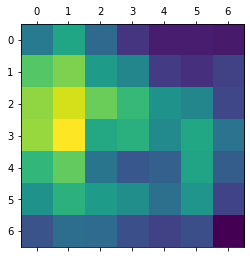

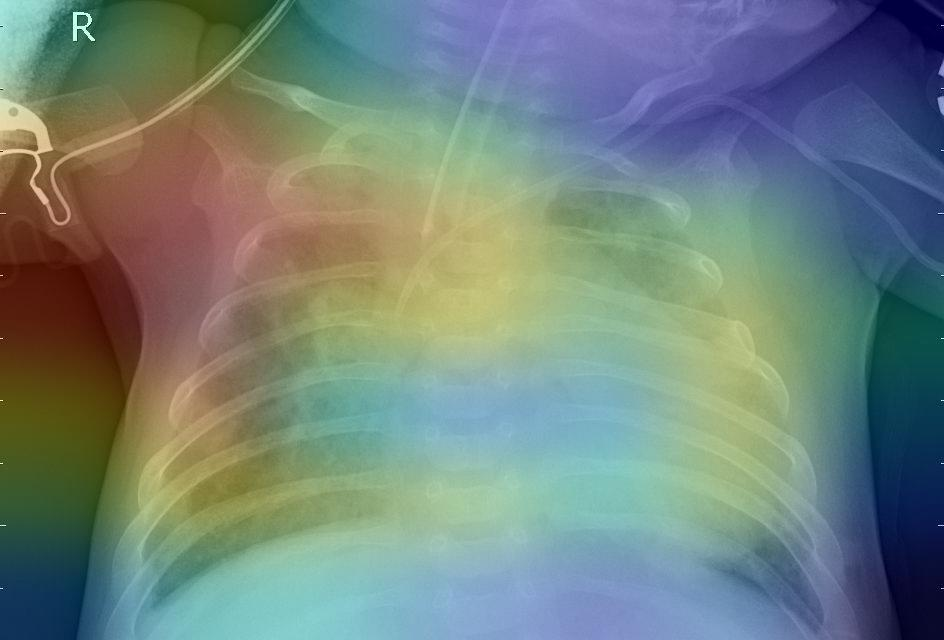

In [34]:
# Prepare image
img_size = (224,224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

# Remove last layer's softmax
MobileNet_model.layers[-1].activation = None

# Print what the top predicted class is
preds = MobileNet_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, MobileNet_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

# Simple Custom CNN

In [35]:
custom_model=tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
custom_model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [64]:
# hist = model.fit(ds_train,validation_data=ds_val,epochs=5)
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='custom_model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

hist = custom_model.fit(
        ds_train,validation_data=ds_val,epochs=5,
        callbacks = callbacks_list)

Epoch 1/5
589/589 [==============================] - 143s 243ms/step - loss: 0.3976 - accuracy: 0.8331 - precision: 0.8534 - recall: 0.9359 - val_loss: 0.2173 - val_accuracy: 0.9140 - val_precision: 0.9673 - val_recall: 0.9149

Epoch 00001: val_loss improved from inf to 0.21734, saving model to custom_model.h5
Epoch 2/5
589/589 [==============================] - 146s 247ms/step - loss: 0.2214 - accuracy: 0.9127 - precision: 0.9411 - recall: 0.9413 - val_loss: 0.1501 - val_accuracy: 0.9426 - val_precision: 0.9711 - val_recall: 0.9510

Epoch 00002: val_loss improved from 0.21734 to 0.15014, saving model to custom_model.h5
Epoch 3/5
589/589 [==============================] - 146s 248ms/step - loss: 0.1915 - accuracy: 0.9342 - precision: 0.9536 - recall: 0.9579 - val_loss: 0.1444 - val_accuracy: 0.9446 - val_precision: 0.9891 - val_recall: 0.9356

Epoch 00003: val_loss improved from 0.15014 to 0.14436, saving model to custom_model.h5
Epoch 4/5
589/589 [==============================] - 154

In [38]:
custom_model = load_model('custom_model.h5')

In [39]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 64)       

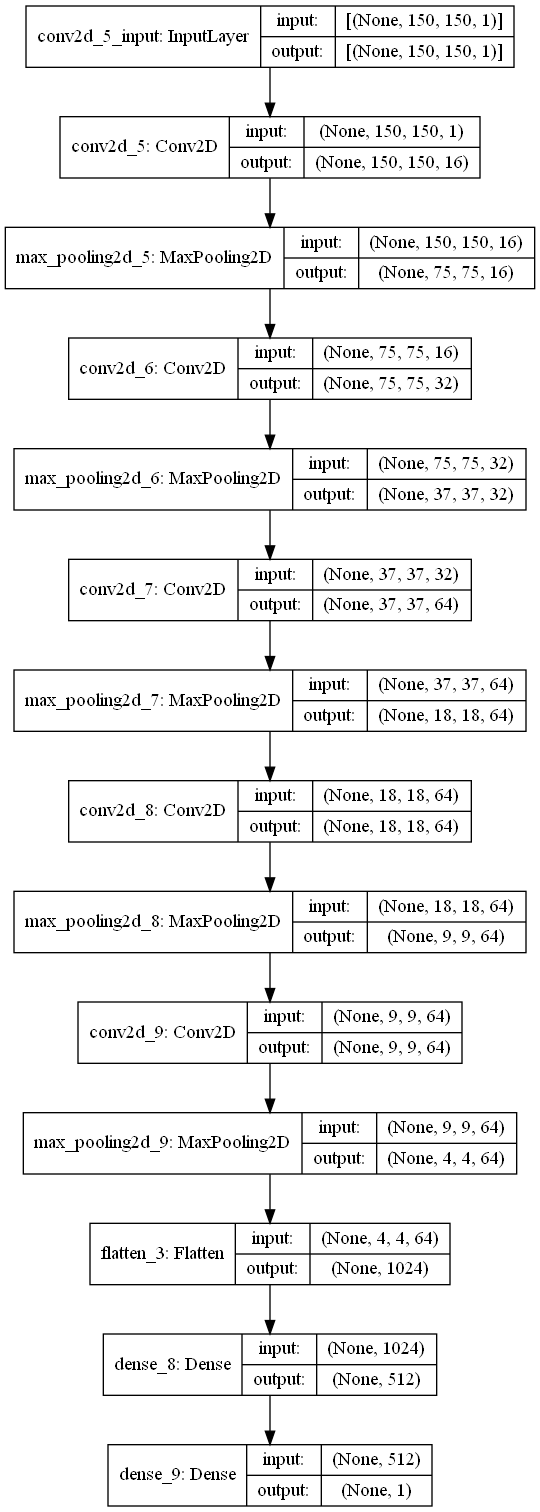

In [41]:
tf.keras.utils.plot_model(
    custom_model, to_file='model1.png', show_layer_names=True, show_shapes=True)
 

In [65]:
np.save('custom_model_history.npy',hist.history)

In [42]:
history_dict=np.load('custom_model_history.npy',allow_pickle='TRUE').item()

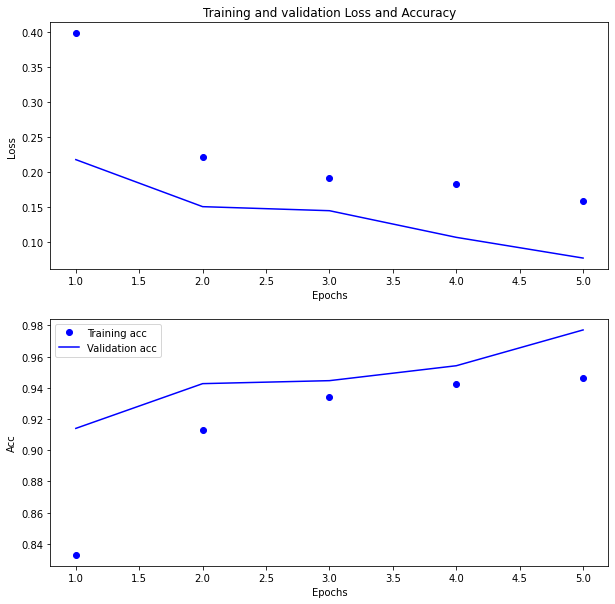

In [43]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [66]:
custom_model.evaluate(ds_test)

624/624 [==============================] - 8s 13ms/step - loss: 0.5797 - accuracy: 0.7821 - precision: 0.7424 - recall: 0.9974


[0.5796606540679932,
 0.7820512652397156,
 0.7423664331436157,
 0.9974358677864075]

In [47]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = custom_model.predict(ds_test, 624)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumo']
print(classification_report(ds_test.classes, y_pred, target_names=target_names))

Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
      Pneumo       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



C:\Users\Noor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Noor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Noor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for each class is given below.
Normal      : 100.0 %
Pneumo      : 0.0 %


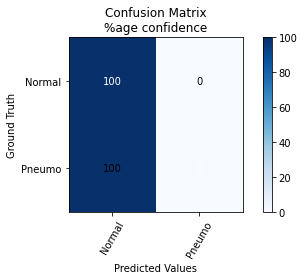

In [48]:
from sklearn import metrics
labels = ['Normal', 'Pneumo']
cm = metrics.confusion_matrix(ds_test.classes, y_pred)
plot_cm(cm, labels,'Confusion Matrix')

In [60]:
last_conv_layer_name = "conv2d_9"

# The local path to our target image
img_path = '1.jpeg'


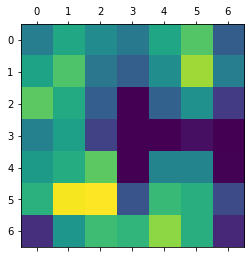

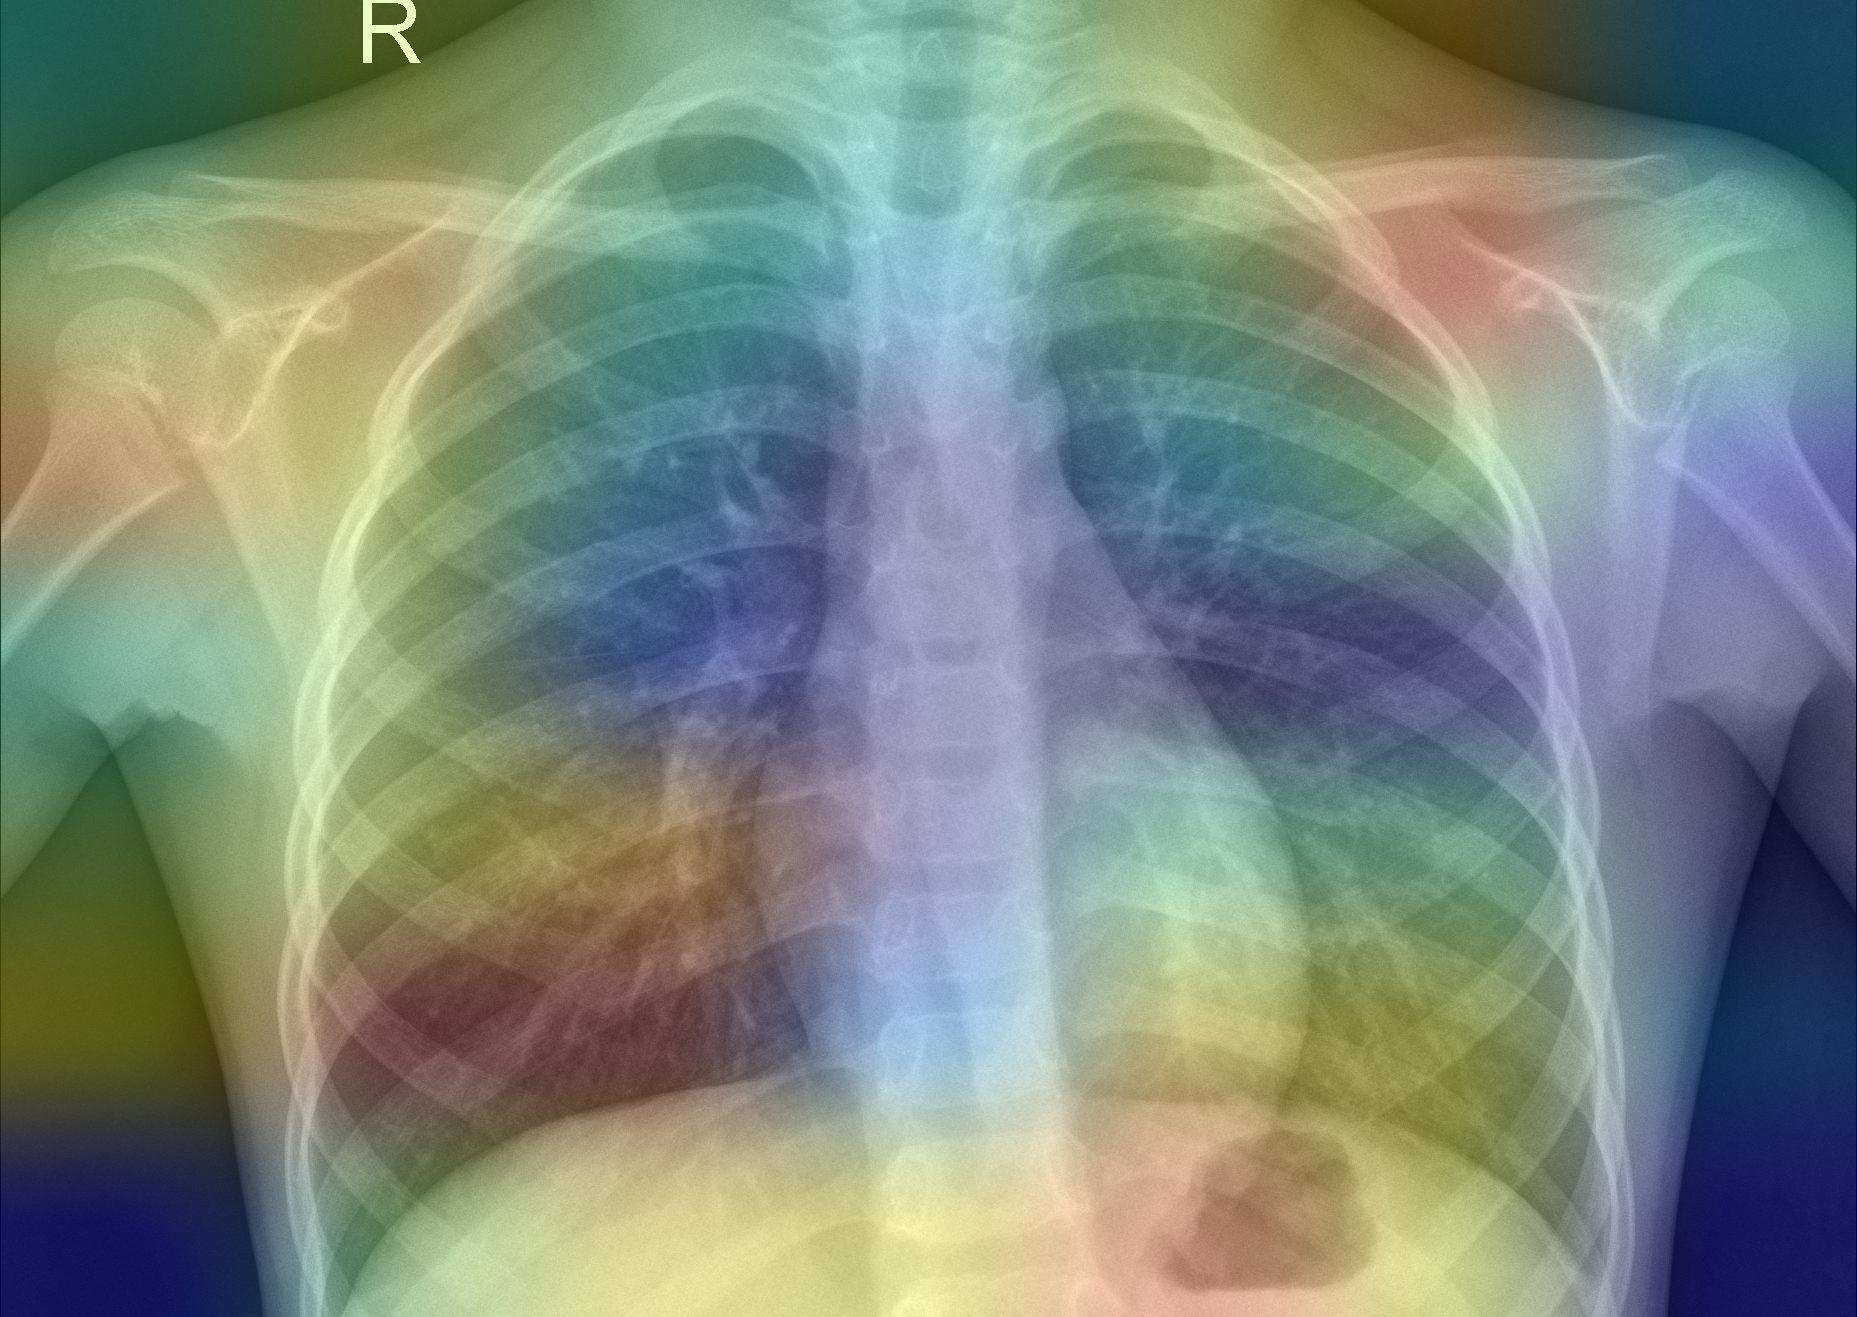

In [73]:
last_conv_layer_name = "conv2d_9"

# The local path to our target image
img_path = '1.jpeg'

# Prepare image
from keras.preprocessing import image

img_size = (150,150)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
custom_model.layers[-1].activation = None

# Print what the top predicted class is
preds = custom_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, custom_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

# Algorithm comparison in terms of accuracy

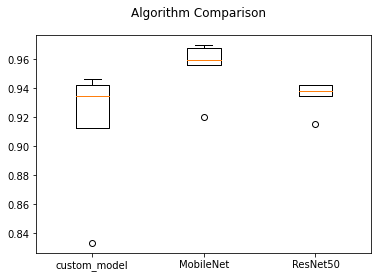

In [90]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
 
model1 = load_model('custom_model.h5')
model2 = load_model('MobileNet.h5')
model4 = load_model('RESNET50.h5')

models = []
models.append(('custom_model', model1))
models.append(('MobileNet', model2))
models.append(('ResNet50', model4))


results = []
names = []
scoring = 'accuracy'
for name, model in models:
	his=np.load(name+'_history.npy',allow_pickle='TRUE').item()
	results.append(his['accuracy'])
	names.append(name)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()